In [3]:
import vedo
import numpy as np
import matplotlib.pyplot as plt

vedo.settings.default_backend = 'vtk'

#load data

directory_name = '2025-02-04_15:10:28_3_passings_10k'
gt_displacement = np.load(directory_name + '/ground_truth_displacement.npy')
pred_displacement = np.load(directory_name + '/prediction_displacement.npy')
gt_grid = np.load(directory_name + '/ground_truth_grid.npy')
pred_grid = np.load(directory_name + '/prediction_grid.npy')
gt_rest = np.load(directory_name + '/ground_truth_rest.npy')
pred_rest = np.load(directory_name + '/prediction_rest.npy')
gt_grid_rest = np.load(directory_name + '/ground_truth_grid_rest.npy')
pred_grid_rest = np.load(directory_name + '/prediction_grid_rest.npy')


error = np.abs(gt_grid - pred_grid)
print('max error:', np.max(error))
print('mean error:', np.mean(error))
print('std error:', np.std(error))
print('error shape:', error.shape)




max error: 0.030902289323066157
mean error: 0.003273131165807733
std error: 0.005093904221169025
error shape: (5042, 3)


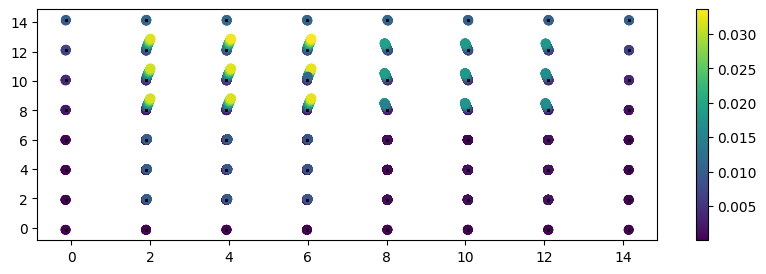

In [4]:
#plot the error on the grid
#size of figure
plt.figure(figsize=(10,3))

# color by error
plt.plot(gt_grid_rest[:,0], gt_grid_rest[:,1], 'o', markersize=1, color='black')
plt.scatter(gt_grid_rest[:,0]+gt_grid[:,0], gt_grid_rest[:,1]+gt_grid[:,1], c=np.linalg.norm(error, axis=1), cmap='viridis')
plt.colorbar()
plt.show()

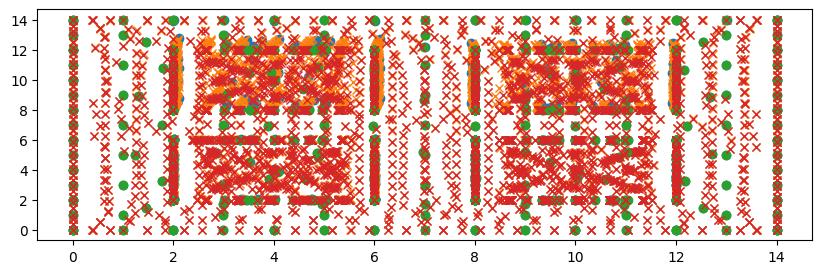

In [5]:
plt.figure(figsize=(10,3))
plt.plot(gt_rest[:,0] + gt_displacement[:,0], gt_rest[:,1] + gt_displacement[:,1], 'o')
plt.plot(pred_rest[:,0] + pred_displacement[:,0], pred_rest[:,1] + pred_displacement[:,1], 'x')

plt.plot(gt_rest[:,0], gt_rest[:,1], 'o')
plt.plot(pred_rest[:,0], pred_rest[:,1], 'x')

plt.show()


In [7]:
def interpolate_vector_field(self, old_grid, vector_field, new_grid):
        from scipy.interpolate import RBFInterpolator

        
        # Create RBF interpolators for each component

        # Remove duplicate points that could cause singularity
        unique_indices = np.unique(old_grid, axis=0, return_index=True)[1]
        old_grid_clean = old_grid[unique_indices]
        vector_field_clean = vector_field[unique_indices]
        try:
            rbf_u = RBFInterpolator(old_grid_clean, vector_field_clean[:, 0], 
                                kernel='cubic',
                                smoothing=1e-3)
            rbf_v = RBFInterpolator(old_grid_clean, vector_field_clean[:, 1],
                                kernel='cubic',
                                smoothing=1e-3)
            rbf_w = RBFInterpolator(old_grid_clean, vector_field_clean[:, 2],
                                kernel='cubic',
                                smoothing=1e-3)
            
            u_new = rbf_u(new_grid)
            v_new = rbf_v(new_grid)
            w_new = rbf_w(new_grid)
            
            return np.array([u_new, v_new, w_new]).T
            
        except np.linalg.LinAlgError:
            # Fallback to simpler kernel if still singular
            rbf_u = RBFInterpolator(old_grid_clean, vector_field_clean[:, 0], 
                                kernel='linear',
                                smoothing=1e-2)
            rbf_v = RBFInterpolator(old_grid_clean, vector_field_clean[:, 1],
                                kernel='linear',
                                smoothing=1e-2)
            rbf_w = RBFInterpolator(old_grid_clean, vector_field_clean[:, 2],
                                kernel='linear',
                                smoothing=1e-2)
            
            u_new = rbf_u(new_grid)
            v_new = rbf_v(new_grid)
            w_new = rbf_w(new_grid)
            
            return np.array([u_new, v_new, w_new]).T

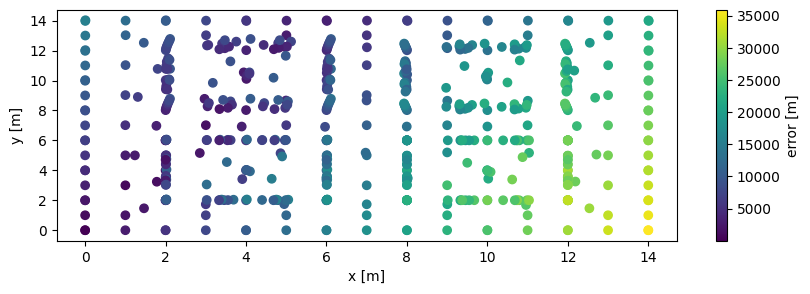

In [8]:
from torch import gt, ne

interpolated_error = interpolate_vector_field(gt_grid_rest, error, gt_grid_rest, gt_rest)

plt.figure(figsize=(10,3))
plt.scatter(gt_rest[:,0]+gt_displacement[:,0], gt_rest[:,1]+gt_displacement[:,1], c=np.linalg.norm(interpolated_error, axis=1), cmap='viridis')
#add units to the axis
plt.xlabel('x [m]')
plt.ylabel('y [m]')
#add units to the colorbar
plt.colorbar(label='error [m]')
plt.show()





In [13]:
from stl import Mesh

# vedo scatter plot
grid = vedo.Points(gt_grid_rest, r=3, c='black')
gt = vedo.Points(gt_rest, r=3, c='red')
error_cmap = np.linalg.norm(error, axis=1)
error_gt = np.linalg.norm(interpolated_error, axis=1)

gt_disp = vedo.Points(gt_rest + gt_displacement, r=10).cmap('viridis', error_gt).add_scalarbar(title='error [m]')


# # generate mesh from Points
# gt_mesh = gt_disp.generate_mesh(mesh_resolution=10)
# pred_mesh = pred_disp.generate_mesh(mesh_resolution=10)




# create plotter
plotter = vedo.Plotter(axes=1, bg='white')
plotter += grid
# plotter += gt
plotter += gt_disp
# add axes
# add colorbar
# show plotter

plotter.show()